In [1]:
import numpy as np
import torch
import torch.nn as nn
import rnns.mante_task as mante
from matplotlib import pyplot as plt
from rnns.modules import RNN
import random
import time

/Users/jbarbosa/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
def loss_mse(output, target, mask):
    """
    Mean squared error loss
    :param output: torch tensor of shape (num_trials, num_timesteps, output_dim)
    :param target: torch tensor of shape (num_trials, num_timesteps, output_dim)
    :param mask: torch tensor of shape (num_trials, num_timesteps, 1)
    :return: float
    """
    # Compute loss for each (trial, timestep) (average accross output dimensions)
    loss_tensor = (mask * (target - output)).pow(2).mean(dim=-1)
    # Account for different number of masked values per trial
    loss_by_trial = loss_tensor.sum(dim=-1) / mask[:, :, 0].sum(dim=-1)
    return loss_by_trial.mean()

### Dataset

In [3]:
input, target, mask, x_val, y_val, mask_val = mante.generate_mante_data(1000)


### Network and Training

In [4]:
hidden_size = 512
input_size = 4
noise_std = 5e-2
alpha = 0.2

net = RNN(
    input_size, hidden_size, 1, noise_std, alpha, train_wi=True, rho=0.1
)


num_examples = input.shape[0]
batch_size = 32
n_epochs = 200
all_losses = []
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

for epoch in range(n_epochs):
    begin = time.time()
    losses = []  # losses over the whole epoch
    for i in range(num_examples // batch_size):
        optimizer.zero_grad()
        random_batch_idx = random.sample(range(num_examples), batch_size)
        batch = input[random_batch_idx]
        output = net(batch)
        loss = loss_mse(output, target[random_batch_idx], mask[random_batch_idx])
        losses.append(loss.item())
        all_losses.append(loss.item())
        loss.backward()
        optimizer.step()
    print(np.mean(losses))

0.9201039838790893
0.6789943945407867
0.6813174462318421
0.641352549791336
0.6332783997058868


KeyboardInterrupt: 

### Analysis

(array([20.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 20.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

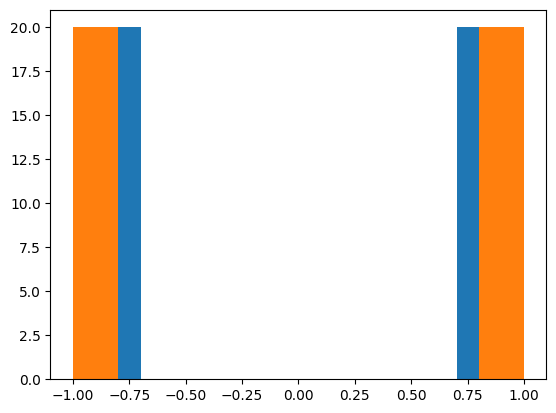

In [ ]:
inputs, labels, mask_train, x_val, y_val, mask_val = mante.generate_mante_data(50)
plt.hist(net(inputs).detach().numpy()[:, -1, :])
plt.hist(labels.detach().numpy()[:, -1, :])
